# Example climb: Pearson & Spearman correlation coefficients

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [ ]:
# Number of input data points
n = 5000

# Run duration in minutes
run_time = 6 * 60

# Number of replicate climbs for each objective function
replicates = 4

### 1.3. Input distributions

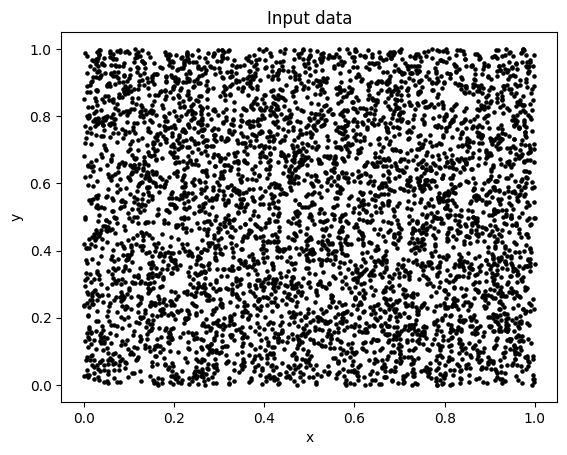

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.rand(n),
    'y': np.random.rand(n)
})

plt.title('Input data')
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Strong Spearman, weak Pearson
### 2.1. Objective function

In [4]:
def objective_spearman_large_pearson_small(x, y):
    '''Maximize Spearman correlation while minimizing Pearson correlation.
    
    Objective function: |Spearman| - |Pearson|
    
    This encourages:
        - Small Pearson correlation (close to 0)
        - Large Spearman correlation (close to +/-1)
    
    Useful for finding non-linear monotonic relationships.
    
    Args:
        x: First variable (array-like)
        y: Second variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with 'Pearson coefficient' and 'Spearman coefficient'
            - objective_value: |Spearman| - |Pearson|
    '''
    
    pearson_corr = pearsonr(x, y)[0]
    spearman_corr = spearmanr(x, y)[0]
    objective = abs(spearman_corr) - abs(pearson_corr)
    
    metrics = {
        'Pearson coefficient': pearson_corr,
        'Spearman coefficient': spearman_corr
    }
    
    return metrics, objective

### 2.2. Run parameters

In [5]:
# Set hyperparameters
step_size = 2.0
perturb_fraction = 0.3
temperature = 500.0
initial_noise = 0.5
cooling_rate = 0.9995
objective_func = objective_spearman_large_pearson_small

### 2.3. Hill climbing run

In [6]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_func,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.4. Results

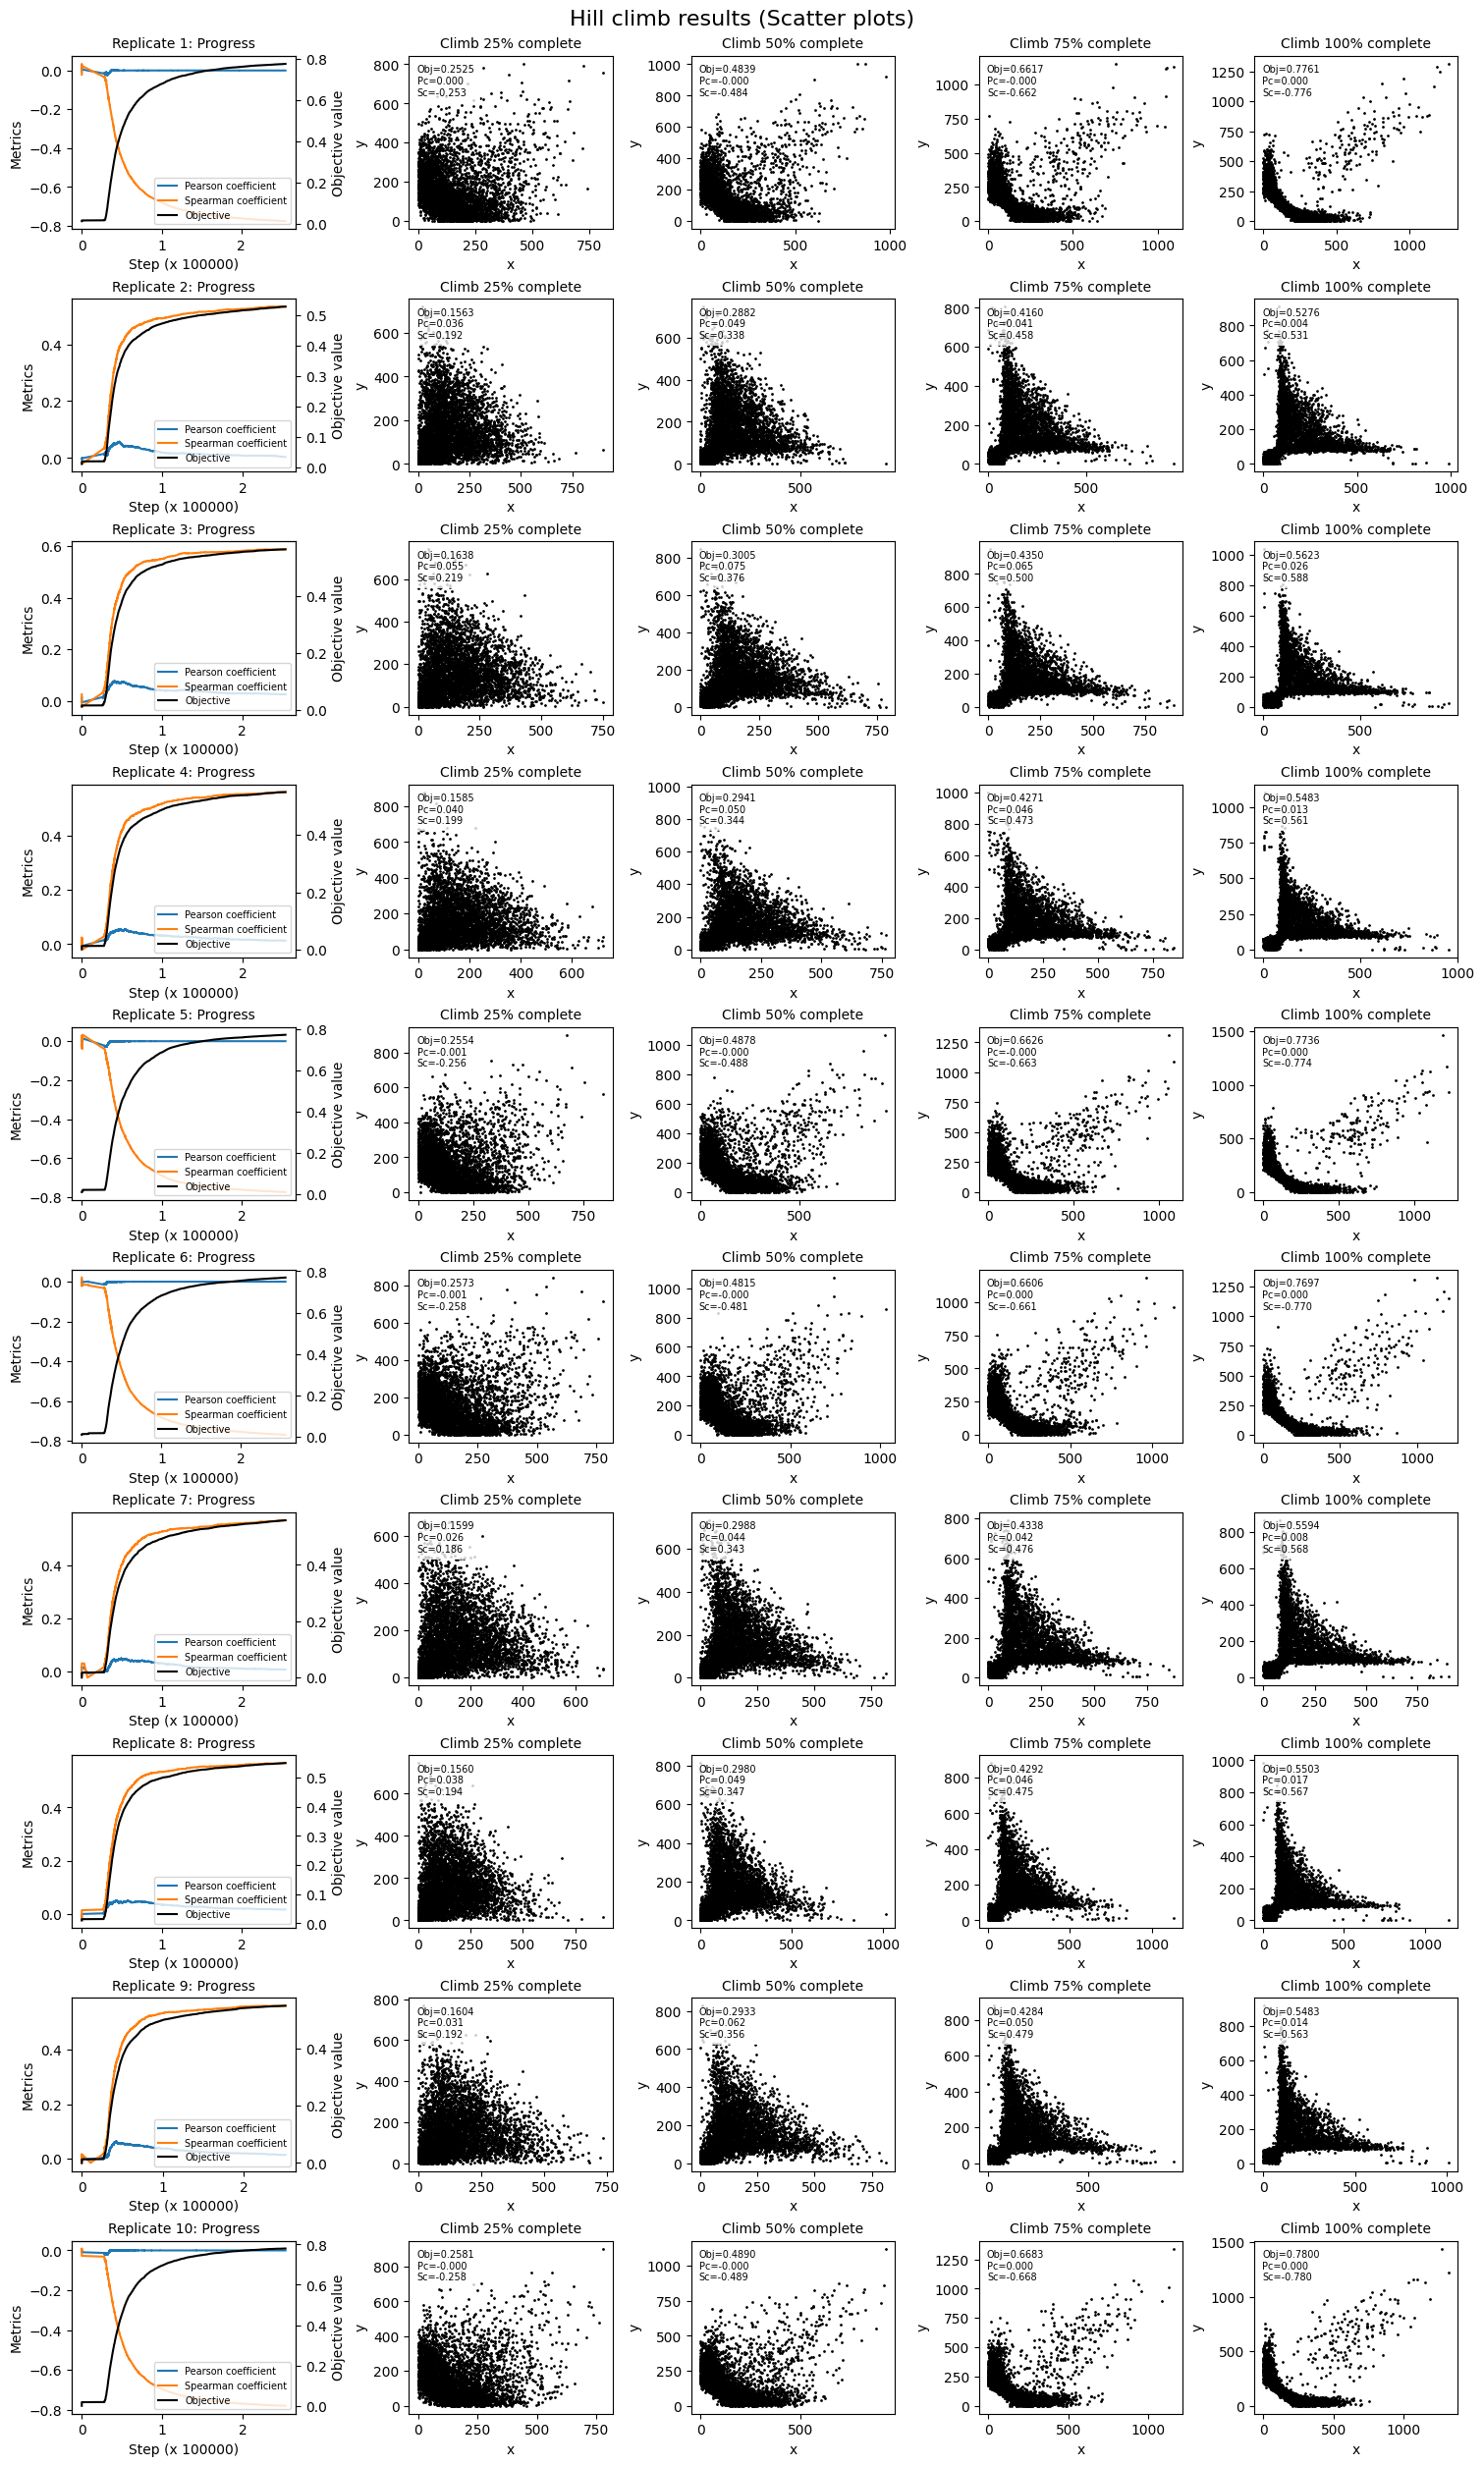

In [7]:
# Display only Pearson and Spearman correlation metrics
climber.plot_results(results, metrics=['Pearson coefficient', 'Spearman coefficient'])

In [8]:
# Save the climber object
with open('../data/02.1_pearson_low_spearman_high.1.pkl', 'wb') as f:
    pickle.dump(climber, f)

## 3. Strong Pearson, weak Spearman

### 3.1. Objective function

In [9]:
def objective_pearson_large_spearman_small(x, y):
    '''Maximize Pearson correlation while minimizing Spearman correlation.
    
    Objective function: |Pearson| - |Spearman|
    
    This encourages:
        - Large Pearson correlation (close to +/-1)
        - Small Spearman correlation (close to 0)
    
    Useful for finding linear relationships with non-monotonic deviations.
    
    Args:
        x: First variable (array-like)
        y: Second variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with 'Pearson coefficient' and 'Spearman coefficient'
            - objective_value: |Pearson| - |Spearman|
    '''
    
    pearson_corr = pearsonr(x, y)[0]
    spearman_corr = spearmanr(x, y)[0]
    objective = abs(pearson_corr) - abs(spearman_corr)
    
    metrics = {
        'Pearson coefficient': pearson_corr,
        'Spearman coefficient': spearman_corr
    }
    
    return metrics, objective

### 3.2. Run parameters

In [10]:
# Set hyperparameters
step_size2 = 2.0
perturb_fraction2 = 0.3
temperature2 = 500.0
initial_noise2 = 0.5
cooling_rate2 = 0.9995
objective_func2 = objective_pearson_large_spearman_small

### 3.3. Hill climbing run

In [11]:
# Create HillClimber instance
climber2 = HillClimber(
    data=data,
    objective_func=objective_func2,
    max_time=run_time,
    step_size=step_size2,
    perturb_fraction=perturb_fraction2,
    temperature=temperature2,
    cooling_rate=cooling_rate2,
    mode='maximize'
)

# Run parallel optimization
results2 = climber2.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise2
)

### 2.4. Results

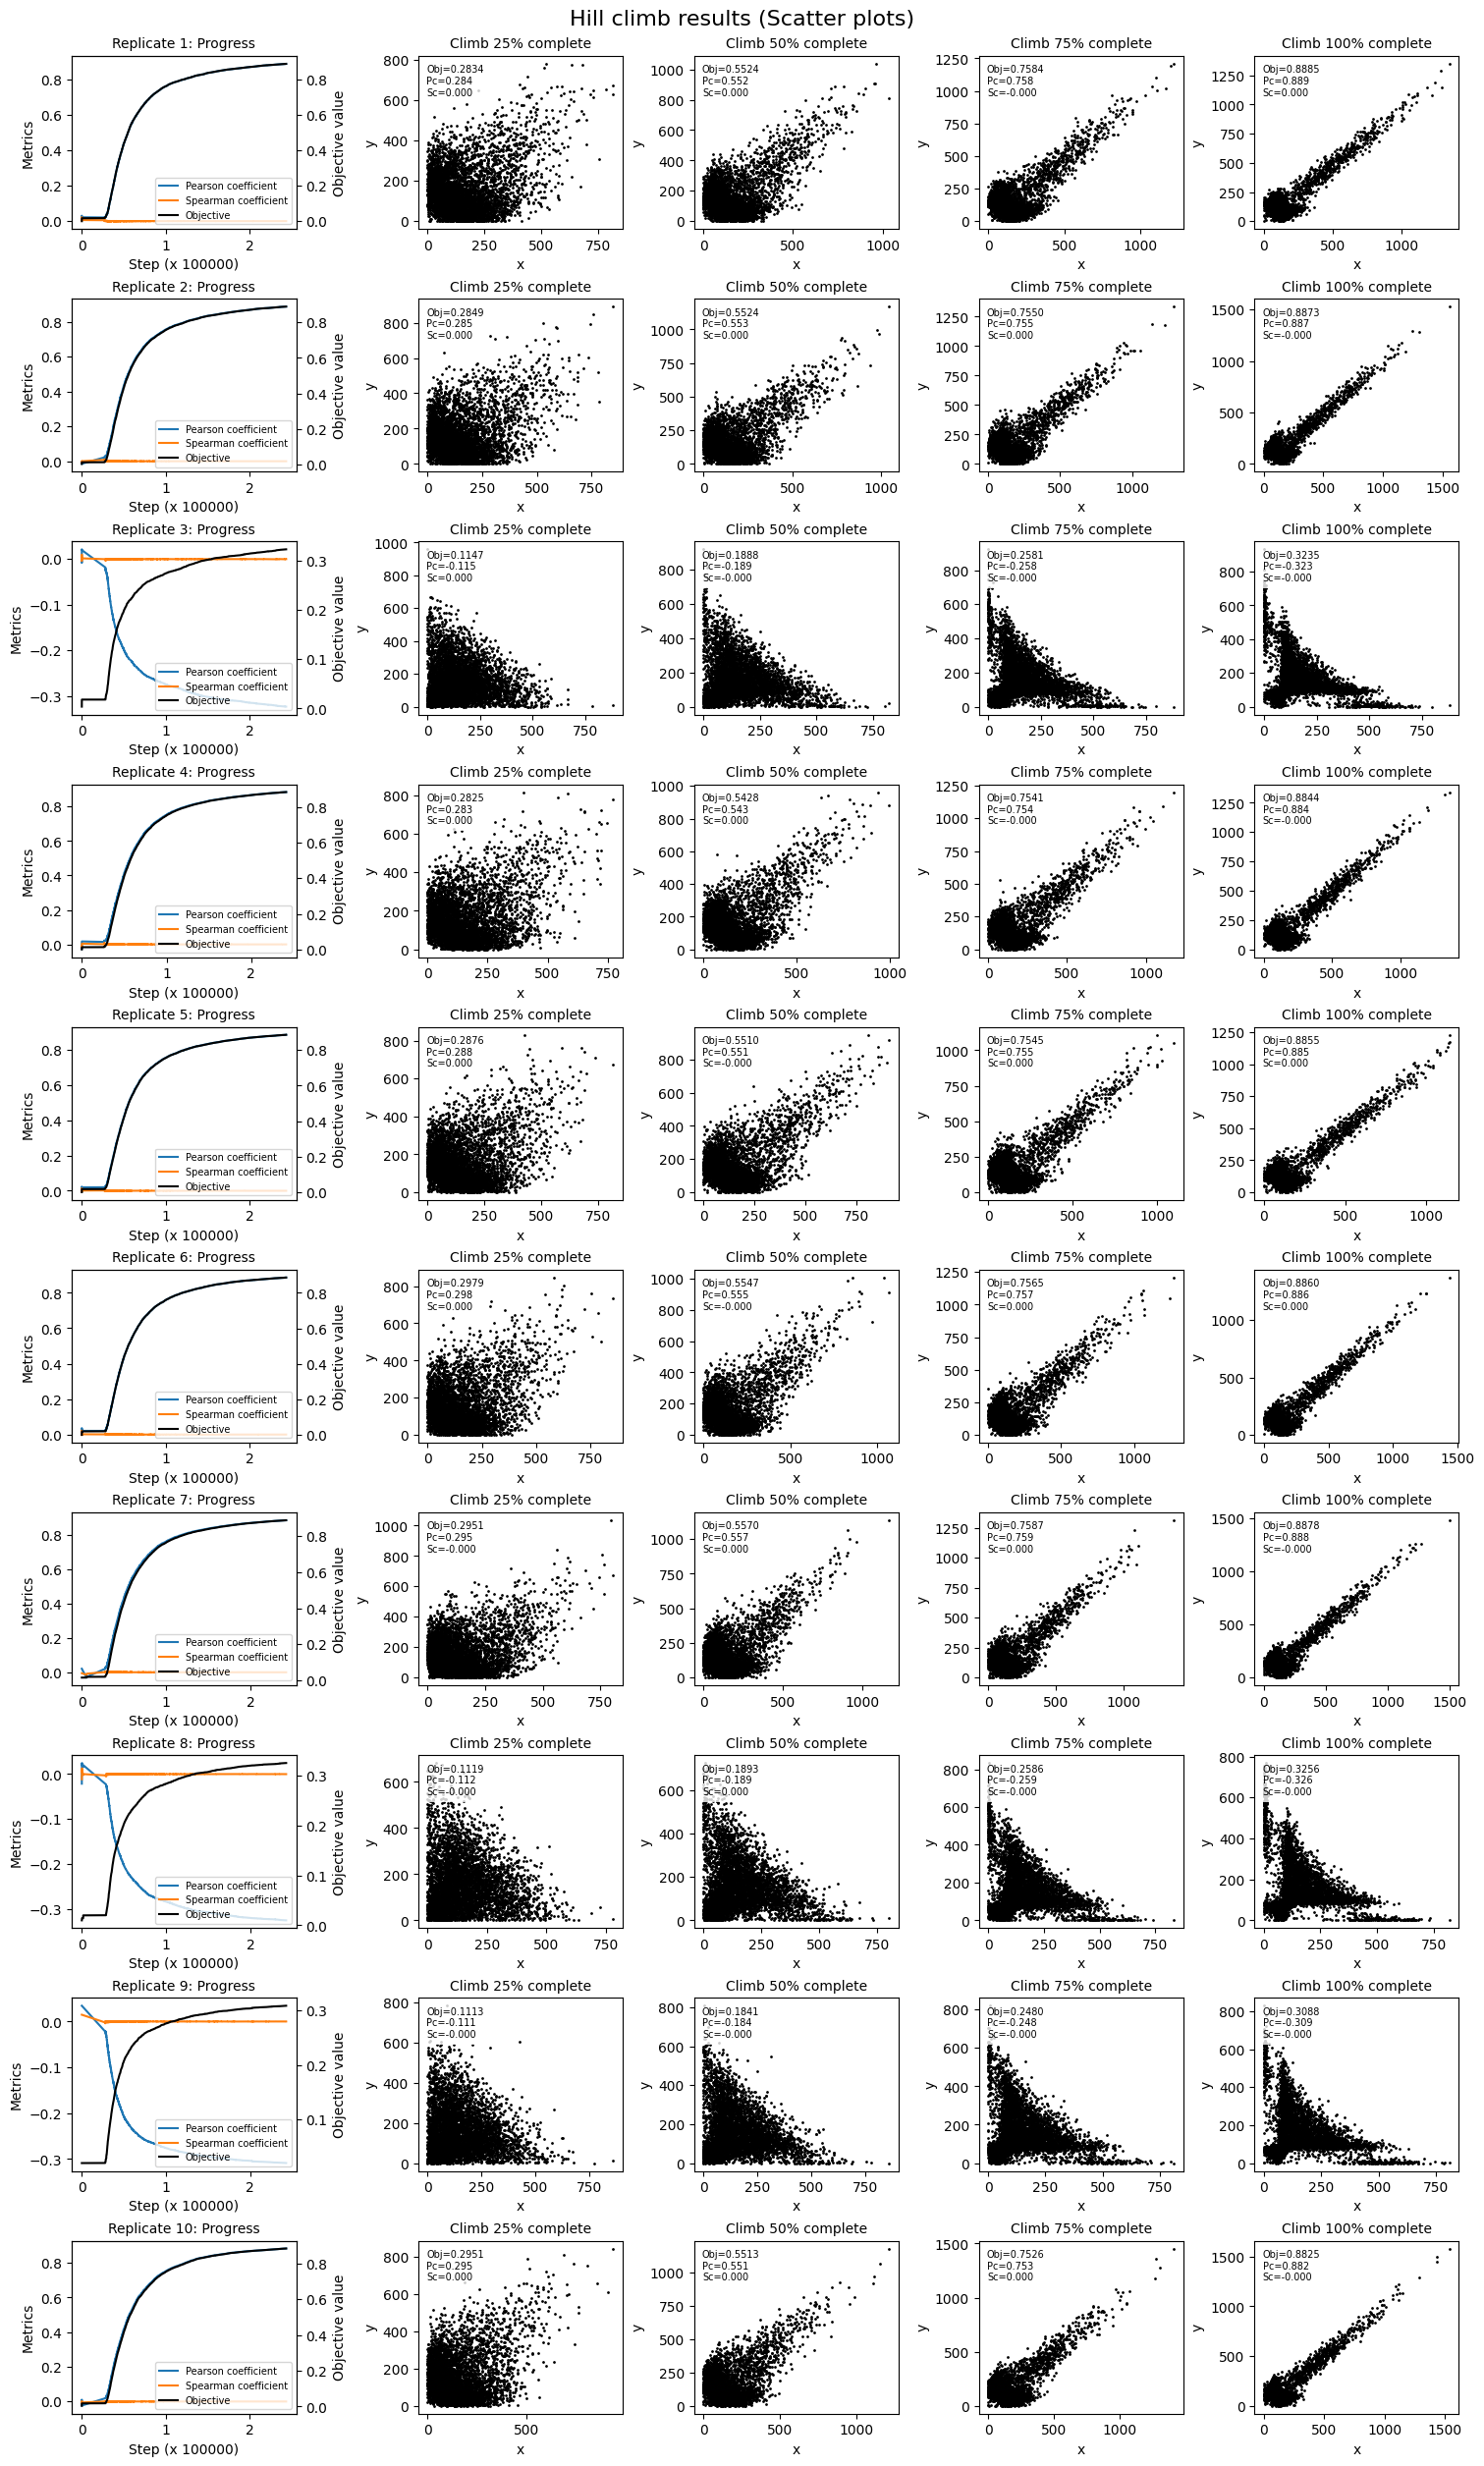

In [12]:
# Display only Pearson and Spearman correlation metrics
climber2.plot_results(results2, metrics=['Pearson coefficient', 'Spearman coefficient'])

In [13]:
# Save the climber object
with open('../data/02.2_pearson_high_spearman_low.1.pkl', 'wb') as f:
    pickle.dump(climber2, f)